In [1]:
from dataclasses import dataclass
from typing import Optional, Tuple

import numpy as np
import numpy.typing

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import linear_regression
from linear_regression import LinearRegression

# Helper Functions

In [2]:
def create_orig_df(x, lr):
    '''
    x: design matrix.
    lr: linear regression object.
    '''
    scores = -lr.influence_scores()[1]
    newton_scores = -lr.one_step_newton()[1]

    # sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
    inds = np.argsort(scores)
    print("inds", inds[:10])
    original_inds = inds # original_inds

    newton_inds = np.argsort(newton_scores)
    print("newton inds", newton_inds[:10])
    original_newton_inds = newton_inds 

    # sort scores.
    sorted_scores = scores[inds]
    print("sorted_scores", sorted(scores)[:10])
    original_sorted_scores = sorted_scores

    sorted_newton_scores = newton_scores[inds]
    print("sorted_newton_scores", sorted_newton_scores[:10])
    original_sorted_newton_scores = sorted_newton_scores

    # residuals
    residuals = lr.residual()
    # print("residuals", residuals[:10])
    # leverages
    leverages = lr.leverage_scores()
    # print("leverages", leverages[:10])

    # x's
    intercept = [pt[0] for pt in x]
    x1 = [pt[1] for pt in x]
    # x2 = [pt[2] for pt in x]

    # x1 = [pt[0] for pt in x]
    # x2 = [pt[1] for pt in x]

    # create a df with residuals, leverages, and coordinates.
    orig_df = pd.DataFrame({'x1': x1, 'y': y, 
                                      'residual': residuals, 'leverage': leverages, 
                            'influence': scores, 'newton': newton_scores})
    
    print(orig_df[:13])
    
    return orig_df, inds, scores, newton_inds, newton_scores


def create_plot(orig_df):
    '''
    orig_df: output from the helper function above.
    '''
    
    # IV. Sort DF by influence score
    sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
    print("index 0 in create_plot", sorted_if_df.index[0])
    
    # sorted_if_df # the indices here are the order which amip drops points.
    index = range(0, len(sorted_if_df))
    
    sorted_if_df['sorted_idx'] = index
    
    # V. Plot Points Dropped
    plt.figure(figsize=(9, 7))

    plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='x', color='black', label='Pop. A') # pop A
    plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B') # pop B


    # Add dropped order positioned by each point
    for index, row in sorted_if_df.iterrows():
        if row['sorted_idx'] <= 9: # indices 2,3,4 are right on top of one another.
            plt.text(row['x1'], row['y'], int(row['sorted_idx']), ha='left', va='top', fontsize=20)


    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Scores Ordered')
    plt.legend()
    plt.show()
    
    return

def plot_dropped_point(x, y, index_to_remove):
    '''
    orig_df: df sorted by original indexing (where the outlier population comes first).
    index_to_drop: index returned from sorting by influence (or one-step newton) scores.
    method: "influence" or "newton"
    '''
    
    # V. Plot Dropped Point at Current Iteration
    plt.figure(figsize=(9, 7))
    plt.scatter(x.T[1][index_to_remove], y[index_to_remove], marker='x', color='black', label='Dropped point')
    
    # match the window of the original plot.
    plt.xlim(-2, 0.05)
    plt.ylim(-7, 3)
    
    plt.xlabel('x1')
    plt.ylabel('y')
    plt.title('Dropped Point')
    plt.legend()
    
    plt.show()
    
    return


# Generate Data

In [3]:
np.random.seed(0)

# I. Generate the data.
num_dimensions = 1
total_observations = 1010

# NOISE ON X.
eps_pop_1 = 0.25
eps_pop_2 = 0.25 

# Mixing proportions
num_observations_pop_1 = 10 # A (small fraction)
num_observations_pop_2 = total_observations - num_observations_pop_1 # B

mean_pop_1 = np.array([25]) # ADJUST DISTANCE OF OUTLIER CLUMP 4/22: in order for AMIP/Newton to fail, if suffices to 
# adjust the location of the outlier group to be far away, relative to the noise.
mean_pop_2 = np.array([0])

vars_pop_1 = np.array([[eps_pop_1]])
vars_pop_2 = np.array([[eps_pop_2]])


In [4]:
# generate the X values for two populations.
x1 = np.random.multivariate_normal(mean_pop_1, vars_pop_1, num_observations_pop_1)
x2 = np.random.multivariate_normal(mean_pop_2, vars_pop_2, num_observations_pop_2)
x = np.append(x1, x2, axis=0)
x

array([[ 2.58820262e+01],
       [ 2.52000786e+01],
       [ 2.54893690e+01],
       ...,
       [-9.09038815e-01],
       [-2.46620351e-02],
       [ 1.19516801e-01]])

In [5]:
# add intercept term. NDArray -> df -> NDArray
df = pd.DataFrame(x)
df.insert(0, 'Ones', 1)
arr = df.values
x = arr
x
# (3/20: make sure that x1, x2 come from this new design matrix.)
x1 = x[:10]
x2 = x[10:]

In [6]:
orig_x = x # (4/01: save this for after running the greedy loop.)

In [7]:
x1_0 = [pt[0] for pt in x1]
x1_1 = [pt[1] for pt in x1]
x2_0 = [pt[0] for pt in x2]
x2_1 = [pt[1] for pt in x2]

In [8]:
# Generating the Y values.
eps1 = 1
epsilon1 = np.random.normal(0, eps1, num_observations_pop_1) # eps is the variance of the outlier distribution.
slope1 = -1 # (-1, -1, 5)
intercept1 = 40 # (-10, 10, 20)
y1 = []
for i in range(num_observations_pop_1):
    y1.append(slope1*x1_1[i] + intercept1 + epsilon1[i]) # May 16: we were indexing the wrong x1 (intercept rather than slope).
    # print(x1_1[i], slope1*x1_1[i], epsilon1[i])

eps2 = 1
epsilon2 = np.random.normal(0, eps2, num_observations_pop_2) # eps is the variance of the outlier distribution.
slope2 = -1
intercept2 = 0
y2 = []
for i in range(num_observations_pop_2):
    y2.append(slope2*x2_1[i] + intercept2 + epsilon2[i])

y = np.concatenate([y1, y2], axis=0)

In [9]:
y1

[13.117643478062464,
 16.4739071028271,
 14.672190275185297,
 15.4429581454282,
 13.275697983091938,
 14.581338818412878,
 14.749208012202885,
 13.396990241320191,
 15.266575016522872,
 14.89191998103373]

In [10]:
# II. Fit the regression.
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

# print(
#     f"Estimated intercept with full dataset: {lr.beta[0]}"
# )

modified_lr_a = LinearRegression(x=x1.T, y=y1)
modified_lr_a.fit()
print(
    f"Estimated beta1 pop A: {modified_lr_a.beta[1]}"
)

modified_lr = LinearRegression(x=x2.T, y=y2)
modified_lr.fit()
print(
    f"Estimated beta1 pop B: {modified_lr.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556261
Estimated beta1 pop A: -0.40383763026701697
Estimated beta1 pop B: -0.989510932401851


In [11]:
# III. Compute influence scores for first coefficient.
# scores = -lr.influence_scores()[0] # effect of removing a data point.
scores = -lr.influence_scores()[1] # after adding an intercept term, take the scores of coefficient 1.
newton_scores = -lr.one_step_newton()[1]

print("A", np.mean(np.abs(scores[:10])), "B", np.mean(np.abs(scores[10:1000])))

# sort indices in ascending order (influence scores are negative, so the largest magnitude scores appear first.)
inds = np.argsort(scores)
print("inds", inds[:10])
original_inds = inds # original_inds

newton_inds = np.argsort(newton_scores)
print("newton inds", newton_inds[:10])
original_newton_inds = newton_inds 

# sort scores.
sorted_scores = scores[inds]
print("sorted_scores", sorted(scores)[:10])
original_sorted_scores = sorted_scores

sorted_newton_scores = newton_scores[inds]
print("sorted_newton_scores", sorted_newton_scores[:10])
original_sorted_newton_scores = sorted_newton_scores

# residuals
residuals = lr.residual()
print("residuals", residuals[:10])
# leverages
leverages = lr.leverage_scores()
print("leverages", leverages[:10])

# create df
orig_df, inds, scores, newton_inds, newton_scores = create_orig_df(x, lr)
orig_df[:10]

A 0.005776252556924636 B 7.388402600927519e-05
inds [  1   8   3   9   5   6   2   7 907 260]
newton inds [  1   8   3   9   5   6   2   7 907 260]
sorted_scores [-0.01285197575131666, -0.008703673485621347, -0.007443140167824765, -0.006882728796325371, -0.006865290194940167, -0.005883322752717006, -0.005564948194915445, -0.001775112253622737, -0.00015887891918680498, -0.00015780060600212659]
sorted_newton_scores [-0.01420247 -0.00959825 -0.00828998 -0.0076063  -0.00754403 -0.00651655
 -0.00616465 -0.00195717 -0.00015905 -0.00015797]
residuals [-0.29704011  3.41104477  1.46008112  1.90527189 -0.16568523  1.87379041
  1.54448911  0.47639287  2.3335602   1.82636428]
leverages [0.10029768 0.0950887  0.09728128 0.10215193 0.10069872 0.08997043
 0.09717211 0.0930222  0.09320166 0.09512805]
inds [  1   8   3   9   5   6   2   7 907 260]
newton inds [  1   8   3   9   5   6   2   7 907 260]
sorted_scores [-0.01285197575131666, -0.008703673485621347, -0.007443140167824765, -0.00688272879632537

,x1,y,residual,leverage,influence,newton
0,25.882026,13.117643,-0.297040,0.100298,0.001150,0.001278
1,25.200079,16.473907,3.411045,0.095089,-0.012852,-0.014202
2,25.489369,14.672190,1.460081,0.097281,-0.005565,-0.006165
3,26.120447,15.442958,1.905272,0.102152,-0.007443,-0.008290
4,25.933779,13.275698,-0.165685,0.100699,0.000643,0.000715
5,24.511361,14.581339,1.873790,0.089970,-0.006865,-0.007544
6,25.475044,14.749208,1.544489,0.097172,-0.005883,-0.006517
7,24.924321,13.396990,0.476393,0.093022,-0.001775,-0.001957
8,24.948391,15.266575,2.333560,0.093202,-0.008704,-0.009598
9,25.205299,14.891920,1.826364,0.095128,-0.006883,-0.007606


In [12]:
# (4/01) Sum of influence and newton scores for population A
print(f"additive influence score for pop A: {sum(sorted_scores[:10])}")
print(f"additive one-step newton score for pop A: {sum(sorted_newton_scores[:10])}")

print(f'indices sorted according to influence score: {original_inds[:10]}')
print(f'indices sorted according to newton score: {original_newton_inds[:10]}')


additive influence score for pop A: -0.05628687112247243
additive one-step newton score for pop A: -0.06219642620013911
indices sorted according to influence score: [  1   8   3   9   5   6   2   7 907 260]
indices sorted according to newton score: [  1   8   3   9   5   6   2   7 907 260]


In [13]:
# Predicted Estimate
print('predicted estimate:\n')
print(f"original estimate + amip additive scores: {lr.beta[1] + sum(scores[:10])}")
print(f'original estimate + newton additive scores: {lr.beta[1] + sum(newton_scores[:10])}')

predicted estimate:

original estimate + amip additive scores: 0.4617287460303055
original estimate + newton additive scores: 0.45601966254319964


In [14]:
# Refit after Removing Flagged Points
# AMIP inds [  1   8   3   9   5   6   2   7 907 260]
AMIP_inds= [1,8,3,9,5,6,2,7,907,260]
new_x_amip= np.delete(x, AMIP_inds, axis=0)
new_y_amip= np.delete(y, AMIP_inds, axis=0)
print(new_x_amip.shape)
print(new_y_amip.shape)
print(x.shape)

# newton inds [  1   8   3   9   5   6   2   7 907 260] - SAME AS AMIP
newton_inds= [1,8,3,9,5,6,2,7,907,260]
new_x_1sN= np.delete(x, newton_inds, axis=0)
new_y_1sN= np.delete(y, newton_inds, axis=0)

(1000, 2)
(1000,)
(1010, 2)


In [15]:
# Refit after removing the points specified by AMIP and Additive 1sN (these indices are the same).
lr = LinearRegression(x=x.T, y=y)
lr.fit()

print(
    f"Estimated beta1 with full dataset: {lr.beta[1]}"
)  # We care about first coefficient (pop A: y is perfectly correlated (slope=1) with x1.)

modified_lr_amip = LinearRegression(x=new_x_amip.T, y=new_y_amip)
modified_lr_amip.fit()
print(
    f"Estimated beta1 after removing subset specified by AMIP: {modified_lr_amip.beta[1]}"
)
print(
    f"Difference in quantities: {lr.beta[1] - modified_lr_amip.beta[1]}"
)

Estimated beta1 with full dataset: 0.5159066036556261
Estimated beta1 after removing subset specified by AMIP: 0.2786236491272701
Difference in quantities: 0.23728295452835602


In [16]:
# IV. Sort DF by influence score
sorted_if_df = orig_df.sort_values(by='influence', ascending=True)
# sorted_if_df # the indices here are the order which amip drops points.
index = range(0, len(sorted_if_df))
sorted_if_df['sorted_idx'] = index
sorted_if_df[:10]

,x1,y,residual,leverage,influence,newton,sorted_idx
1,25.200079,16.473907,3.411045,0.095089,-0.012852,-0.014202,0
8,24.948391,15.266575,2.333560,0.093202,-0.008704,-0.009598,1
3,26.120447,15.442958,1.905272,0.102152,-0.007443,-0.008290,2
9,25.205299,14.891920,1.826364,0.095128,-0.006883,-0.007606,3
5,24.511361,14.581339,1.873790,0.089970,-0.006865,-0.007544,4
6,25.475044,14.749208,1.544489,0.097172,-0.005883,-0.006517,5
2,25.489369,14.672190,1.460081,0.097281,-0.005565,-0.006165,6
7,24.924321,13.396990,0.476393,0.093022,-0.001775,-0.001957,7
907,-0.592343,-1.531547,-1.287928,0.001091,-0.000159,-0.000159,8
260,-0.594430,-1.520626,-1.275932,0.001091,-0.000158,-0.000158,9


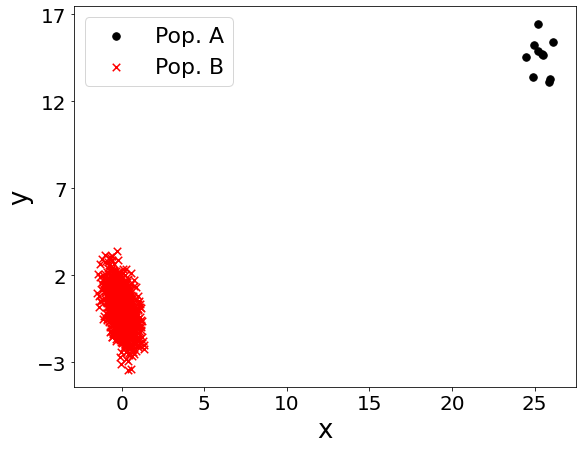

In [17]:
# V. Plot Points Dropped

plt.figure(figsize=(9, 7))

plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A', s=56) # pop A
plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B', s=56) # pop B

plt.xlabel('x', fontsize=26) 
plt.ylabel('y', fontsize=26)

# Set the size of tick marks
plt.xticks(np.arange(0, 30, 5), fontsize=20) # custom range of ticks.
plt.yticks(np.arange(-3, 20, 5), fontsize=20)

# Line of best fit
x_values = np.linspace(min(orig_df['x1']), max(orig_df['x1']), 100) # Define range of x values
y_values = lr.beta[1] * x_values # Calculate corresponding y values based on y = 2x

# plt.plot(x_values, y_values, color='gray', linestyle='--')


# plt.title('Simpson`s paradox', fontsize=22)
plt.legend(fontsize=22)
# plt.savefig('simpsons_paradox_may26.pdf')
plt.show()

In [18]:
# How/why is the condition number of pop B so much larger, just by shifting things over?

print(
    f"Condition number of full dataset: {np.linalg.cond(x)}"
)

print(
    f"Condition number Pop A: {np.linalg.cond(x1)} Pop B: {np.linalg.cond(x2)}"
)

Condition number of full dataset: 2.58516818699332
Condition number Pop A: 1333.5416362663614 Pop B: 2.0390310495837616


We define the failure of an approximation algorithm in two different ways: (i) when there exists a small fraction (alpha < 0.01) of data (which is user-predefined) that we can drop to change conclusions, yet the algorithm reports such a fraction does not exist or (ii) if there exists a small fraction of data that we can drop to change conclusions, and we remove the points suggested by the algorithm, but we do not see a change in conclusions. The second definition is motivated by the person who is willing to run their algorithm twice, such that even when the algorithm does not report a change in conclusions, the user is willing to rerun their analysis by removing the points suggested by the algorithm.

We illustrate Simpson's paradox as a realistic data setting under which AMIP and 1sN may fail. This example is set up with two populations of points. Population A consisted of $<1%$ of the datapoints. The DGP for population A is $X \sim N(5, 0.01)$ and $Y = -X + 20 + \epsilon$, while that of population B is $X \sim N(0, 0.01)$ and $Y = -X + \epsilon$, where $\epsilon \sim N(0, 1)$.

The regression on population A is $Y = -X + 20 + \epsilon$ while that of population B is $Y = -X + \epsilon$, where $\epsilon \sim N(0, 1)$. In this example, dropping only the 10 datapoints in population A suffices to flip the effect size of the regression from 2.82 to -1.05.

We observe that AMIP fails in both the type (i) and type (ii) sense. That is, AMIP approximates that the largest effect size for the removal of 10 datapoints is -0.149 (failure type i), which is not enough to change the sign. In addition, AMIP fails to correctly identify subset A as the correct subset to remove (failure type ii). Similarly, 1sN fails in this case. That is, 1sN approximates that the largest effect size for the removal of 10 datapoints is -0.165 (failure type i). 1sN also fails to correctly identify subset A as the correct subset to remove (failure type ii). In running the greedy versions of these algorithms on this Simpson's paradox example, we find that both greedy AMIP and greedy 1sN are able to succeed in identifying population A as an influential subset that reverses the sign.


# Eigenvectors: Mechanism For Failure

In [19]:
def normalize_vector(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v 
    return v / norm

In [20]:
# compute (xtxinv - x2tx2inv)
xtxinv = np.linalg.inv(x.T @ x)
x2tx2inv = np.linalg.inv(x2.T @ x2)
M = xtxinv - x2tx2inv

In [21]:
print(xtxinv)
print(x2tx2inv)

[[ 9.97760517e-04 -3.39975790e-05]
 [-3.39975790e-05  1.50862666e-04]]
[[0.00100282 0.00010825]
 [0.00010825 0.00415021]]


In [22]:
M

array([[-5.06276549e-06, -1.42243630e-04],
       [-1.42243630e-04, -3.99934473e-03]])

In [23]:
# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta)
rs
xstrs = x1.T @ rs
xstrs

array([ 14.36826931, 362.35833158])

In [24]:
# norm of M
# M[1:2]
print(f'norm of M: {np.linalg.norm(M[1:2])}')
print(f'norm of V: {np.linalg.norm(xstrs)}')            

norm of M: 0.004001873500834008
norm of V: 362.6430857327517


## Verifying Error Term Expression (June 25th)

In [25]:
import math

# empirical error: beta(w) - beta^{IF}(w) 
beta_w = modified_lr.beta[1]
beta_IF_w = lr.beta[1] + sum(scores[:10])
print(beta_w - beta_IF_w)

# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta)
rs
xstrs = x1.T @ rs
xstrs

# analytic error: etM2v
print(-M[1:2] @ xstrs)

# print norm values
print('norm M:', np.linalg.norm(M[1:2]))
print('norm v:', np.linalg.norm(xstrs))  

# normed vectors
norm_m_vec = normalize_vector(-M[1:2])[0]
norm_v_vec = normalize_vector(xstrs)

# cosine similarity
costheta = norm_m_vec @ norm_v_vec
theta = math.acos(costheta) * (180.0 / math.pi)
print('theta in degrees:', theta)

# new June 25th - should be the same as the old.
print(norm_m_vec)
print(norm_v_vec)

-1.4512396784321564
[1.45123968]
norm M: 0.004001873500834008
norm v: 362.6430857327517
theta in degrees: 0.23374336751129535
[0.03554426 0.9993681 ]
[0.03962097 0.99921478]


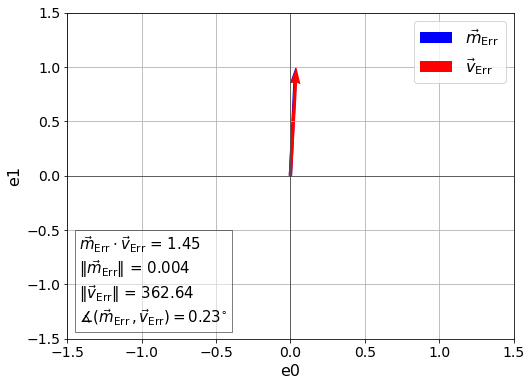

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
# v1 = np.array([-1.42243630e-04, -3.99934473e-03]) # M[:, 1]
# v1 = largest_eigenvector
# v2 = np.array([[-0.03937332, -0.99922457]]) # error vector
# v2 = norm_error_vector

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, norm_m_vec[0], norm_m_vec[1], angles='xy', scale_units='xy', scale=1, color="blue", label=r'$\vec{m}_{\mathrm{Err}}$')
plt.quiver(0, 0, norm_v_vec[0], norm_v_vec[1], angles='xy', scale_units='xy', scale=1, color="red", label=r'$\vec{v}_{\mathrm{Err}}$')

textstring = '\n'.join((
    r'$\vec{m}_{\mathrm{Err}} \cdot \vec{v}_{\mathrm{Err}}$ = 1.45',
    r'$\|\vec{m}_{\mathrm{Err}}\|$ = 0.004',
    r'$\|\vec{v}_{\mathrm{Err}}\|$ = 362.64',
    r'$\measuredangle{ (\vec{m}_{\mathrm{Err}}\, , \vec{v}_{\mathrm{Err}}) } = 0.23^{\circ} $'
)) 

# Adding a text box
plt.text(-1.42, -1.36, textstring, fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

# Setting the limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

# plt.title('Plot of Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=16)

# plt.savefig('simpsons_vector_june25.pdf')
plt.savefig('mv.simpsons.failure.pdf')
plt.show()

In [27]:
# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)
print(f'eigenvalues: {s}')

# The operator norm is the largest singular value
normM = np.max(s)
print(normM)

largest_eigenvector = U[:, 0] # Simpson's Paradox: Largest eigenvalue is 4.00e-03.
second_eigenvector = U[:, 1]

print(largest_eigenvector)

eigenvalues: [4.00440388e-03 3.61956546e-09]
0.004004403875550985
[-0.03554429 -0.9993681 ]


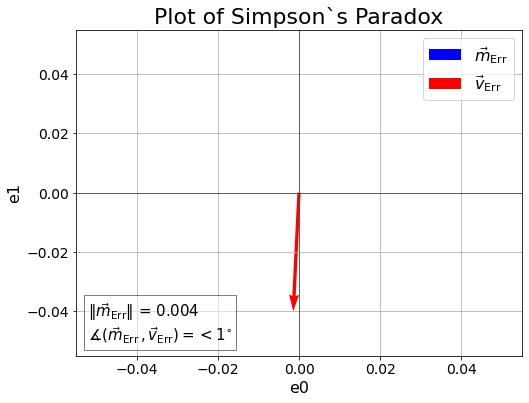

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
v1 = np.array([-5.06276549e-06, -1.42243630e-04])
v2 = np.array([-1.42243630e-04, -3.99934473e-03])

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, 10*v1[0], 10*v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label=r'$\vec{m}_{\mathrm{Err}}$')
plt.quiver(0, 0, 10*v2[0], 10*v2[1], angles='xy', scale_units='xy', scale=1, color="red", label=r'$\vec{v}_{\mathrm{Err}}$')

textstring = '\n'.join((
    r'$\|\vec{m}_{\mathrm{Err}}\|$ = 0.004',
    r'$\measuredangle{ (\vec{m}_{\mathrm{Err}}\, , \vec{v}_{\mathrm{Err}}) } = <1^{\circ} $'
))

# Adding a text box
plt.text(-0.052, -0.05, textstring, fontsize = 15, 
         bbox = dict(facecolor = 'white', alpha = 0.5))

# Setting the limits and labels
# plt.xlim(-1, 1)
# plt.ylim(-1, 1)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Plot of Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=16)

plt.savefig('simpsons_vector_june25.pdf')
plt.show()

In [39]:
### Compute the Error Vector.
x1y1 = x1.T @ y1
Sigma_s = x1.T @ x1
Sigma_inv = np.linalg.inv(x.T @ x)
xty = x.T @ y

In [40]:
error_vec = x1y1 - Sigma_s @ Sigma_inv @ Sigma_s @ xty

In [41]:
norm_error_vec = normalize_vector(error_vec)
norm_error_vec

array([-0.03937332, -0.99922457])

Simpson's paradox: the largest eigenvector aligns closely with Xsys

In [105]:
largest_ev_dot_error_vec=largest_eigenvector.T @ norm_error_vec
largest_ev_dot_error_vec

0.9999926589878864

In [106]:
# second_ev_dot_x1y1=second_eigenvector.T @ norm_x1y1
# second_ev_dot_x1y1
# second_ev_dot_x2y2=second_eigenvector.T @ norm_x2y2
# second_ev_dot_x2y2

In [57]:
second_ev_dot_error_vec=second_eigenvector.T @ norm_error_vec
second_ev_dot_error_vec

0.0038317059303912618

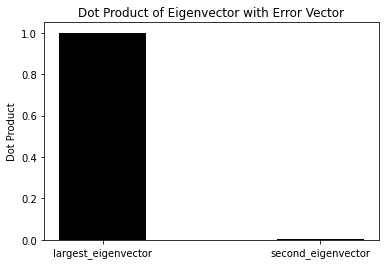

In [63]:
import matplotlib.pyplot as plt

# Values from the outputs related to dot products
eigenvalues = [largest_ev_dot_error_vec, second_ev_dot_error_vec]
eigenvectors = ['largest_eigenvector', 'second_eigenvector']

# Creating the bar plot with thinner bars
plt.bar(eigenvectors, eigenvalues, color=['black', 'black'], width=0.4)  # Adjust the width here
plt.ylabel('Dot Product')
plt.title('Dot Product of Eigenvector with Error Vector')
plt.savefig('simpsons_barplot.pdf')
plt.show()

We illustrate Multicollinearity as another data setting under which AMIP and 1sN may fail. This example is also set up with two populations of points. Population A consisted of $<1%$ of the datapoints. The DGP for population A is $X \sim N(-1, 0.01)$ and $Y = -5X - 10 + \epsilon$, while that of population B is $X \sim N(0, 0.001)$ and $Y = -X + \epsilon$, where $\epsilon \sim N(0, 1)$.


In [64]:
print(
    f"Condition number of full dataset: {np.linalg.cond(x)}"
)

print(
    f"Condition number Pop A: {np.linalg.cond(x1)} Pop B: {np.linalg.cond(x2)}"
)

Condition number of full dataset: 2.58516818699332
Condition number Pop A: 1333.5416362663614 Pop B: 2.0390310495837616


# Why does the error vector align with the largest eigenvector of the diff in inverse hessians?

notice that the largest eigenvector aligns well with the vector e1 = (0, 1). this is why the error is large in x, but is it large in the intercept?

This is because Xs^Trs = (\sum r_i , \sum r_i x_i). In order for Xs^Trs \approx (0, 1), and more generally (0, 1, 0, 0, 0) when our axis of interest is ei, we must have that \sum r_i x_i >> \sum r_i x_j. This means that the reason this counterexample is happening is because the outlier blob has super large (xi values) (in the case where the inliers are mean-centered, it means they are far from the inlier blob in the ei direction, relative to the other directions.)

In [33]:
M

array([[-5.06276549e-06, -1.42243630e-04],
       [-1.42243630e-04, -3.99934473e-03]])

In [59]:
# compute the Singular Value Decomposition
U, s, V = np.linalg.svd(M)
print(f'eigenvalues: {s}')
print(U)

# The operator norm is the largest singular value
normM = np.max(s)
# print(s)

largest_eigenvector = U[:, 0] # Simpson's Paradox: Largest eigenvalue is 4.00e-03.
second_eigenvector = U[:, 1]

eigenvalues: [4.00440388e-03 3.61956546e-09]
[[-0.03554429 -0.9993681 ]
 [-0.9993681   0.03554429]]


In [51]:
# vector norm of M[:, 1]
np.sqrt(M[0,1]**2 + M[1,1]**2)

0.004001873500834008

In [53]:
# vector norm of M[:, 0]
np.sqrt(M[0,0]**2 + M[1,0]**2)

0.00014233369897324402

In [37]:
M1_norm = normalize_vector(M[:,1])
M1_norm

array([-0.03554426, -0.9993681 ])

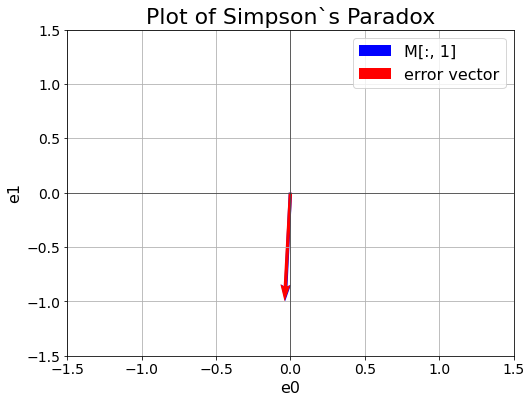

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
# v1 = np.array([-1.42243630e-04, -3.99934473e-03]) # M[:, 1]
v1 = M1_norm
# v2 = np.array([[-0.03937332, -0.99922457]]) # error vector
v2 = norm_error_vec

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label="M[:, 1]")
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label="error vector")

# Setting the limits and labels
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Plot of Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=16)
plt.show()

In [22]:
# Xs^Trs = (\sum_i r_i , \sum_i xiri)
rs = (y1 - x1 @ lr.beta)
rs
xstrs = x1.T @ rs
xstrs

array([ 14.36826931, 362.35833158])

In [28]:
rs

array([-0.29704011,  3.41104477,  1.46008112,  1.90527189, -0.16568523,
        1.87379041,  1.54448911,  0.47639287,  2.3335602 ,  1.82636428])

In [31]:
x1[:, 1] *  rs

array([-7.68799989, 85.95859631, 37.21654643, 49.76655253, -4.29684407,
       45.92915338, 39.34592829, 11.87376906, 58.21857129, 46.03405825])

In [32]:
x1[:, 1]

array([25.88202617, 25.2000786 , 25.48936899, 26.1204466 , 25.933779  ,
       24.51136106, 25.47504421, 24.9243214 , 24.94839057, 25.20529925])

## Extra Plots

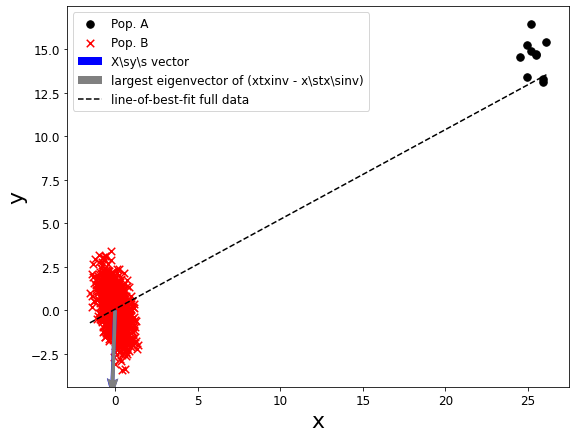

In [62]:
# V. Plot Points Dropped

plt.figure(figsize=(9, 7))

plt.scatter(orig_df[:10]['x1'], orig_df[:10]['y'], marker='o', color='black', label='Pop. A', s=56) # pop A
plt.scatter(orig_df[10:]['x1'], orig_df[10:]['y'], marker='x', color='r', label='Pop. B', s=56) # pop B

plt.xlabel('x', fontsize=22)  # Larger font for x-axis label
plt.ylabel('y', fontsize=22)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=12)  # Larger ticks for x-axis
plt.yticks(fontsize=12)  # Larger ticks for y-axis

plt.xlabel('x')
plt.ylabel('y')

# Line of best fit
x_values = np.linspace(min(orig_df['x1']), max(orig_df['x1']), 100) # Define range of x values
y_values = lr.beta[1] * x_values + lr.beta[0] # Calculate corresponding y values based on y = 2x

# Define the vector x\sy\s
vector_x = 5*norm_error_vec[0] 
vector_y = 5*norm_error_vec[1] 

# Plot the vector starting from the origin (0,0)
plt.quiver(0, 0, vector_x, vector_y, angles='xy', scale_units='xy', scale=1, color='blue', label='X\sy\s vector')

# Define the vector largest_eigenvector
eigvec_x = 5*largest_eigenvector[0] 
eigvec_y = 5*largest_eigenvector[1] 

# Plot the vector starting from the origin (0,0)
plt.quiver(0, 0, eigvec_x, eigvec_y, angles='xy', scale_units='xy', scale=1, color='gray', 
           label='largest eigenvector of (xtxinv - x\stx\sinv)')



plt.plot(x_values, y_values, color='black', linestyle='--', label='line-of-best-fit full data')
plt.legend(fontsize=12)
# plt.savefig('simpsons_may17.pdf')
# plt.savefig('simpsons_may18.pdf')

plt.show()

### Operator Norm of M
Largest eigenvalue is 4.00e-03

### Cos(theta)
the cosine similarity between the largest eigenvector and the error vector is 0.99.

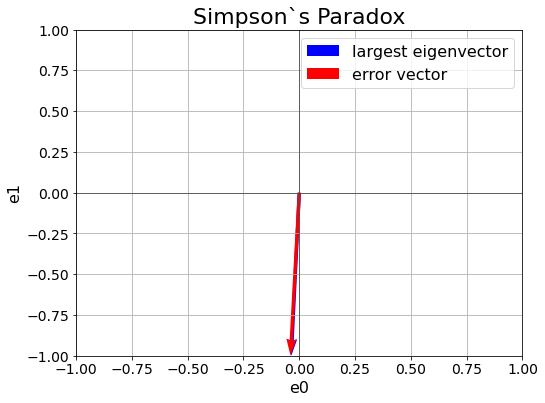

In [103]:
import numpy as np
import matplotlib.pyplot as plt

# Define three vectors
v1 = np.array([-0.03554429, -0.9993681])
v2 = np.array([-0.03937332, -0.99922457])

# Plotting
plt.figure(figsize=(8, 6))
plt.quiver(0, 0, v1[0], v1[1], angles='xy', scale_units='xy', scale=1, color="blue", label="largest eigenvector")
plt.quiver(0, 0, v2[0], v2[1], angles='xy', scale_units='xy', scale=1, color="red", label="error vector")

# Setting the limits and labels
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True)
plt.xlabel('e0', fontsize=16)  # Larger font for x-axis label
plt.ylabel('e1', fontsize=16)  # Larger font for y-axis label

# Set the size of tick marks
plt.xticks(fontsize=14)  # Larger ticks for x-axis
plt.yticks(fontsize=14)  # Larger ticks for y-axis

plt.title('Simpson`s Paradox', fontsize=22)
plt.legend(fontsize=16)
plt.savefig('simpsons_paradox_vector_plot.pdf')
plt.show()